In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import load_model
from datetime import datetime, timedelta
import os

In [2]:
# Step 1: Load data
combined = pd.read_csv('../data/processed/combined_data.csv', index_col='Date', parse_dates=True)
tsla_close = combined['TSLA']
end_date = (datetime.now() - timedelta(days=1)).strftime('%Y-%m-%d')

In [3]:
future_periods = 252  # Approx. 1 year of business days
future_dates = pd.date_range(start=end_date, periods=future_periods + 1, freq='B')[1:]

In [4]:
# Step 3: ARIMA forecast
train = tsla_close['2015-07-01':end_date]
model_arima = auto_arima(train, seasonal=True, m=12)
arima_fit = ARIMA(train, order=model_arima.order, seasonal_order=model_arima.seasonal_order).fit()
arima_future = arima_fit.forecast(steps=future_periods)
arima_future_series = pd.Series(arima_future, index=future_dates)

C:\Project\Time-Series-Forecasting-Weeek11\venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Project\Time-Series-Forecasting-Weeek11\venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Project\Time-Series-Forecasting-Weeek11\venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Project\Time-Series-Forecasting-Weeek11\venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Project\Time-Series-Forecasting-Weeek11\venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: '

In [5]:
# Step 4: LSTM forecast
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train.values.reshape(-1,1))

def create_sequences(data, seq_length=60):
    xs = []
    for i in range(len(data) - seq_length):
        xs.append(data[i:i + seq_length])
    return np.array(xs)

# Prepare input for LSTM
last_sequence = train_scaled[-60:]  # Last 60 days
X_future = last_sequence.reshape(1, 60, 1)
model_lstm = load_model('lstm_model.h5')

lstm_future = []
for _ in range(future_periods):
    pred = model_lstm.predict(X_future, verbose=0)
    lstm_future.append(pred[0, 0])
    X_future = np.roll(X_future, -1, axis=1)
    X_future[0, -1, 0] = pred[0, 0]

lstm_future = scaler.inverse_transform(np.array(lstm_future).reshape(-1, 1)).flatten()
lstm_future_series = pd.Series(lstm_future, index=future_dates)

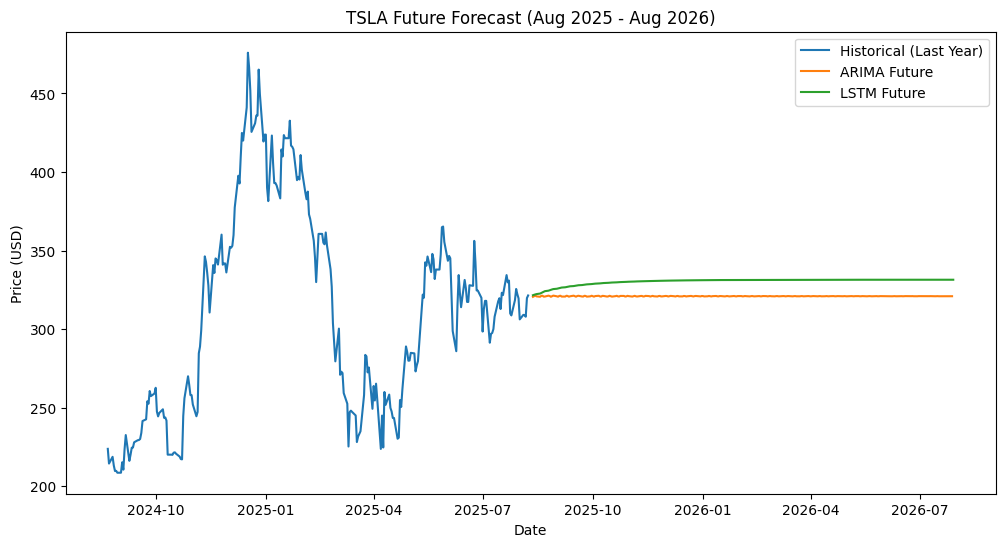

In [6]:
# Step 5: Visualize future forecasts
plt.figure(figsize=(12,6))
plt.plot(train[-252:], label='Historical (Last Year)')
plt.plot(future_dates, arima_future_series, label='ARIMA Future')
plt.plot(future_dates, lstm_future_series, label='LSTM Future')
plt.title(f'TSLA Future Forecast (Aug 2025 - Aug 2026)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.savefig('../reports/figures/future_forecast.png')
plt.show()

In [7]:
# Step 6: Analyze trends
arima_trend = 'Upward' if arima_future_series[-1] > arima_future_series[0] else 'Downward'
lstm_trend = 'Upward' if lstm_future_series[-1] > lstm_future_series[0] else 'Downward'
print(f"ARIMA Trend: {arima_trend}")
print(f"LSTM Trend: {lstm_trend}")

# Save forecasts
arima_future_series.to_csv('../data/processed/arima_future_forecast.csv')
lstm_future_series.to_csv('../data/processed/lstm_future_forecast.csv')

ARIMA Trend: Downward
LSTM Trend: Upward


C:\Users\zyona\AppData\Local\Temp\ipykernel_1860\408184402.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  arima_trend = 'Upward' if arima_future_series[-1] > arima_future_series[0] else 'Downward'
C:\Users\zyona\AppData\Local\Temp\ipykernel_1860\408184402.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  lstm_trend = 'Upward' if lstm_future_series[-1] > lstm_future_series[0] else 'Downward'
